In [61]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import curve_fit,least_squares
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import radioactivedecay as rd

rcParams['figure.dpi']=150

In [62]:
#cargo los datos obtenidos:


####################################################################################################
#Se toma para la incertidumbre de las medidas temporales el siguiente valor:
s_T = 0.2 #[s]
#Se toma para la incertidumbre del campo magnético el siguiente valor:
s_B = 4 #[mT] debido a variaciones en el contador
#Se toma para la incertidumbre de la intensidad el siguiente valor:
s_I = 0.01 #[A]
#Se toma para el radio el valor medio:
r = 50 #[mm]
#Defino un termino de masa:
m = 0.510999

####################################################################################################
#Radiación de fondo
data_fondo = np.loadtxt('rad_fondo.txt', comments='%')

N_f = data_fondo[0]################  Número de cuentas  ############################################


T_f = data_fondo[1]################        Tiempo[s]    ############################################



####################################################################################################


#Semicircunferencia derecha
data_cd = np.loadtxt('circ_d.txt', comments='%')

N_cd = data_cd[:,0]################  Número de cuentas  ############################################


T_cd = data_cd[:,1]################        Tiempo[s]    ############################################



####################################################################################################



#Semicircunferencia izquierda
data_ci = np.loadtxt('circ_i.txt', comments='%')

N_ci = data_ci[:,0]################  Número de cuentas  ############################################


T_ci = data_ci[:,1]################        Tiempo[s]       #########################################



####################################################################################################



#Circunferencia completa
data_cc = np.loadtxt('circ_c.txt', comments='%')

N_cc = data_cc[:,0]################  Número de cuentas         #####################################


T_cc = data_cc[:,1]################        Tiempo[s]           #####################################



####################################################################################################



#Medidas Krypton
data_Kr = np.loadtxt('krypton.txt', comments='%')

N_kr = data_Kr[:,1]################    Número de cuentas Kr    #####################################


t_kr = data_Kr[:,2]################        Tiempo[s]           #####################################

mB_kr = data_Kr[:,0]###############        Campo[mT]           #####################################

A_0_Kr = 167000####################   Actividad inicial [Bq]   #####################################

T_vm_Kr = 10.76####################   Periodo semides. [años]  #####################################

intervalo_Kr = 39.97################   tiempo desde fab. [años] #####################################
s_intervalo_Kr = 0.25##############   error t. fab fab. [años] #####################################


####################################################################################################



#Medidas Radio
data_Ra = np.loadtxt('radio.txt', comments='%')

N_ra = data_Ra[:,1]################    Número de cuentas Ra    #####################################


t_ra = data_Ra[:,2]################        Tiempo[s]           #####################################

mB_ra = data_Ra[:,0]###############        Campo[mT]           #####################################

A_0_Ra = 3330  ####################   Actividad inicial [Bq]   #####################################

T_vm_Ra = 1600 ####################   Periodo semides. [años]  #####################################

intervalo_Ra = 39.64###############   tiempo desde fab. [años] #####################################
s_intervalo_Ra = 0.25##############   error t. fab fab. [años] #####################################


####################################################################################################



#Medidas Sodio
data_Na = np.loadtxt('sodio.txt', comments='%')

N_na = data_Na[:,1]################    Número de cuentas Na    #####################################


t_na = data_Na[:,2]################        Tiempo[s]           #####################################

mB_na = data_Na[:,0]###############        Campo[mT]           #####################################

A_0_Na = 74000 ####################   Actividad inicial [Bq]   #####################################

T_vm_Na = 2.6  ####################   Periodo semides. [años]  #####################################

intervalo_Na = 1.23################   tiempo desde fab. [años] #####################################
s_intervalo_Na = 0.083#############   error t. fab fab. [años] #####################################


################################################################################################


#Medidas pares Intensidad (A) y campo magnético B(mT):

datos_pos = np.loadtxt('I_Bpos.txt', comments='%')
datos_neg = np.loadtxt('I_Bneg.txt', comments='%')
datos_pos_bajada = np.loadtxt('I_Bpos_bajada.txt', comments='%')
datos_neg_bajada = np.loadtxt('I_Bneg_bajada.txt', comments='%')


I_pos = datos_pos[:,0]
B_pos = datos_pos[:,1]

I_neg = datos_neg[:,0]
B_neg = datos_neg[:,1]

I_pos_bajada = datos_pos_bajada[:,0]
B_pos_bajada = datos_pos_bajada[:,1]

I_neg_bajada = datos_neg_bajada[:,0]
B_neg_bajada = datos_neg_bajada[:,1]







#### Lo primero que realizaremos será el cálculo de la tasa de desintegración real, para ello necesitaremos:

#Input---> Numero de cuentas(N) con su tiempo de medida(T), siendo sus incertidumbres s(N) y s(T) respectivamente

#Tasa medidas(R_m)---> $R_m = \frac{N}{T}$ y su incertidumbre s(R_m)

#Tasa de radiacion de fondo(R_f)---> $R_f = \frac{N}{T}$ y su incertidumbre s(R_f)

#Tasa corregida con radiacion de fondo(R_c)---> $R_c = R_m - R_f$

#Tiempo muerto(t) e incertidumbre (s(t))---> a partir de las medidas de circunferencia completa (C_c), semicircunferencia derecha(SC_d) e izquierda(SC_i) obtenemos t=(chorizo) y s(t)=(chorizaco)

#Tasa real(R)---> $R = \frac{R_c}{1-t\cdot R_c}$ y su incertidumbre s(R)

In [63]:
############################################################################################################################################################################################
#Defino función lineal para calcular relación entre B e I:
def histeresis(x,a,b):
    return (a*x) + b


#Defino la función para calcular incertidumbre de cuentas:

def error_cuentas(x):##########  x es el numero de cuentas N  ##########
    return np.sqrt(x) 



############################################################################################################################################################################################
#Defino función para calcular la tasa de desintegración:

def tasa_desintegracion(x,a):  ##########  a es el tiempo de medida T  ###########
    return (x/a)

#la incertidumbre de la tasa de desintegración:

def error_tasa_desintegracion(x,a,sx,sa):##########  sx es el error en N y sa el error en T  ##########
    return np.sqrt( (sx / a)**2 + (sa * x / a**2)**2 )




############################################################################################################################################################################################
#Defino la tasa corregida con la radiación de fondo:

def tasa_corregida(m,f):##########  m es la tasa medida y f la tasa de fondo  ##########
    return m-f

#la incertidumbre de la tasa corregida:

def error_tasa_corregida(m,f,sm,sf):##########  sm es el error de la tasa y sf el error en la tasa de fondo ##########
    return np.sqrt( sm**2 + sf**2 )



############################################################################################################################################################################################
#Defino el tiempo muerto del detector:

def tiempo_muerto(cd,ci,cc):##########  cd es la tasa circ.derecha, ci es la tasa circ.izquierda y cc es la tasa circ. completa ##########
    return ( cd*ci - np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) / ( cd * ci* cc )

#la incertidumbre del tiempo muerto:

def error_tiempo_muerto(cd,ci,cc,scd,sci,scc):##########  scd, sci y scc son los errores de las tasas ##########
    return np.sqrt( ( scd * (( ( ( cd * ci* cc ) * ( ci - ( ci * cc**2 - 2 * cd * ci * cc - cc * ci**2 + 2 * cd * ci**2 ) / ( 2 * np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) ) - ci * cc * ( cd * ci - np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) / ( ( cd * ci* cc )**2 )) )**2 + ( sci * (( ( ( cd * ci* cc ) * ( cd - ( cd * cc**2 - 2 * ci * cd * cc - cc * cd**2 + 2 * ci * cd**2 ) / ( 2 * np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) ) - cd * cc * ( cd * ci - np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) / ( ( cd * ci* cc )**2 )) )**2 + ( scc * (( ( ( cd * ci * cc ) * ( ( ci * cd**2 + cd * ci**2 - 2 * cd * ci * cc ) / ( 2 * np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) ) - ( cd * ci * ( cd * ci - np.sqrt( cd * ci * ( cc - cd ) * ( cc - ci ) ) ) ) ) / ( ( cd * ci* cc )**2 )) )**2 )



############################################################################################################################################################################################
#Defino la tasa real:

def tasa_real(tc,t):##########  tc es la tasa corregida y t el tiempo muerto  ##########
    return ( tc ) / ( 1 - tc * t )


#la incertidumbre de la tasa real:

def error_tasa_real(tc,t,stc,st):##########  stc y st son los errores de la tasa corregida y el tiempo muerto respectivamente  ##########
    return np.sqrt( ( stc / ( 1 - tc * t ) )**2 + ( ( st * tc**2 ) / ( 1 - tc * t )**2 )**2 )



############################################################################################################################################################################################
#Defino el peso estadistico:


def w_i(i):##########  i es el error del tiempo muerto  ##########
    return 1/(i**2)
#Media ponderada:
def media_ponderada(z,j):##########  z es el tiempo muerto y j el peso estadistico ##########
    return (sum(z*j))/(sum(j))
def s_media_ponderada(j):
    return np.sqrt(1/(sum(j)))




############################################################################################################################################################################################
#Defino función para calcular la energía cinética en [eV]

def energia_cinetica(b,r,m):##########  b es el campo magnético en [mT], r el radio en [mm] y m = 0.510999  ##########
    return np.sqrt( 9 * (b * r)**2 * 1e4 + m**2 * 1e12 ) - m * 1e6

def error_energia_cinetica(b,r,m,sb):
    return ( sb * b * 9e4 * r**2 ) / ( np.sqrt( 9 * (b * r)**2 * 1e4 + m**2 * 1e12 ) )



#Defino función para calcular el momento en [eV/c]

def momento_lineal(b,r):##########  b es el campo magnético en [mT], r el radio en [mm] ##########
    return b * r * 1e-6

def error_momento_lineal(r,sb):
    return r * sb * 1e-6





############################################################################################################################################################################################
#Defino función para la actividad y su error de una muestra [Bq]

def actividad(A_0,t,T_vm): # A_0 es la actividad inicial [Bq], t el tiempo desde adquisicion y T_vm el periodo de semidesintegracion ambos en [años]##########
    return (A_0*np.exp((-t*np.log(2)/T_vm)))


def error_actividad(A_0,t,T_vm,s_t): ###s_t es el error temporal asociado al tiempo de adquisición de la muestra#########
    return A_0*np.exp((-t*np.log(2)/T_vm))*(s_t)*(np.log(2)/T_vm)



############################################################################################################################################################################################
#Defino función Fermi esfericas como:

def Fermi(Z,A,p,signo):
    return ((2 + 2* np.sqrt(1 - (Z/137)**2) ) / (scipy.special.gamma(1 + 2 * np.sqrt(1 - (Z/137)**2))**2) * (( 2 * p * (1.2 * A**(1/3)) / 6.582122e-16 )**(2 * np.sqrt(1 - (Z/137)**2) - 2)) * ( np.exp(signo * np.pi *(Z*(3e8 * (1.602e-19)**2)/(p * 6.582122e-16)) ) ) * (abs(scipy.special.gamma(np.sqrt(1 - (Z/137)**2) + (Z*(3e8 * (1.602e-19)**2)/(p * 6.582122e-16))*1j*signo )))**2)
#recordar que eta lleva - para positron y + para electron

def eta(signo,Z,p):
    return signo*(Z*((1.602e-19)**2)*3e8 / (6.582122e-16))*(1/p)

def s_eta(signo,Z,p,sp):
    return signo*(Z*((1.602e-19)**2)*3e8 / (6.582122e-16))*(-1/p**2)*sp

def error_Fermi(F,eta,seta):
    return seta*( 2*np.pi*(1-np.exp(-2*np.pi*eta)) -  (2*np.pi*eta)*(2*np.pi*np.exp(-2*np.pi*eta))      )/((1-np.exp(-2*np.pi*eta))**2)


############################################################################################################################################################################################
#Defino la función de Fermi-Kurie como:
                      
def Fermi_Kurie(R,p,F,S):
    return np.sqrt( R / (p**2 * F * S) )                
                      
def error_Fermi_kurie(R,p,F,S,sR,sp,sF,sS):
    return np.sqrt( ((sR**2)/(4*R*F*S*p**2)) + ((R*sF**2)/(4*S*(p*F)**2)) + ((R*sS**2)/(4*F*(p*S)**2)) + ((R*sp**2)/(F*S*p**4)) )













                      
############################################################################################################################################################################################
#Defino función para calcular test chi^2:


def chi2(y,i,s):###y son los datos y obtenidos, i los datos obtenidos mediante la funcion f(x) a partir de y, s la incertidumbre de y##############
    return sum(((y-i)**2)/(s))
                      
                      
                      
############################################################################################################################################################################################                      
#Defino la función a la que ajustaremos los datos de los diagramas de Fermi-Kurie para el sodio


def ajuste_fermi_kurie(x,b,a):# donde x será la energia cinética y el parametro b nos dará el Q-value
    return (b-x)/a                      


############################################################################################################################################################################################
#Defino la función a la que ajustaremos los datos de los diagramas de Fermi-Kurie para el Kripton


def ajuste_fermi_kurie_kr(x,b,a):# 
    return ( ( b-x ) * np.sqrt( p_kr_lineal**2 + ((b-x)/3e8)**2 ) )/a                    


############################################################################################################################################################################################


# Caracterización ciclo de histéresis:

----------------------------------------POLARIDAD POSITIVA-----------------------------------------------
pendiente= 117.49069871519565
error pendiente= 0.5975069152302955
termino indep= 13.265880274890247
error termino indep= 0.6741128614457759
----------------------------------------POLARIDAD NEGATIVA-----------------------------------------------
pendiente= 118.37474936607481
error pendiente= 0.6724574293328058
termino indep= -4.576361995221467
error termino indep= 0.7024934929943039
------------------------------------Test Chi POLARIDAD POSITIVA------------------------------------------
Chi^2= 61.817717964906755
Para 44 grados de libertad y un chi=61.82 nos da que los datos no se ajustan a una recta al 96% de seguridad
------------------------------------Test Chi POLARIDAD NEGATIVA------------------------------------------
Chi^2= 58.77375747636667
Para 48 grados de libertad y un chi=58.77 nos da que los datos no se ajustan a una recta al 86% de seguridad
---------------------------

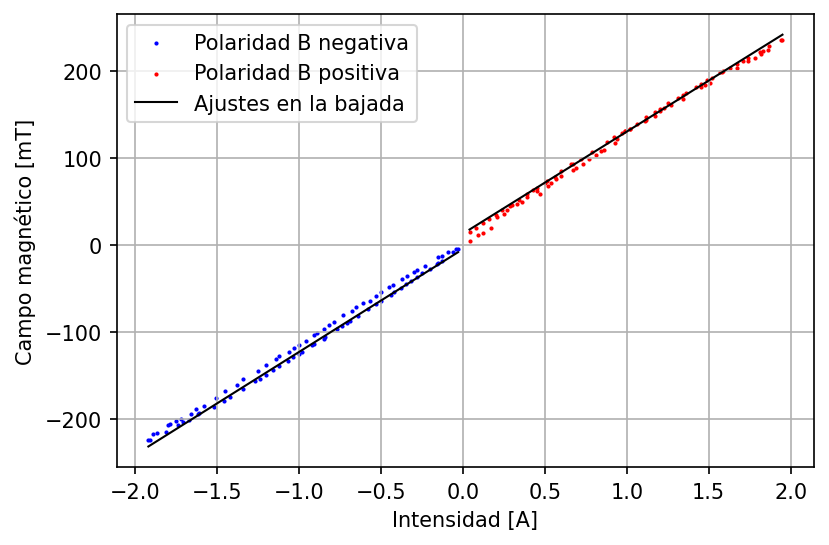

In [64]:
#Tomaremos los datos  correspondientes a las bajadas: 

# Ajuste intensidad +I(A) y campo magnético +B(mT) de la forma B= aI + b:
popt, pcov = curve_fit(histeresis, I_pos_bajada, B_pos_bajada)
perr = np.sqrt(np.diag(pcov))
a_positivo = popt[0]
b_positivo = popt[1]
s_a_positivo = perr[0]
s_b_positivo = perr[1]
# Ajuste intensidad -I(A) y campo magnético -B(mT) de la forma B= aI + b:
popt, pcov = curve_fit(histeresis, I_neg_bajada, B_neg_bajada)
perr = np.sqrt(np.diag(pcov))
a_negativo = popt[0]
b_negativo = popt[1]
s_a_negativo = perr[0]
s_b_negativo = perr[1]

#Realicemos un test Chi^2 y veamos el nivel de confianza para:

#bajada(+B):
i_B_pos = a_positivo * I_pos_bajada + b_positivo
Chi_B_pos = chi2(B_pos_bajada,i_B_pos,s_B)

#bajada(-B):
i_B_neg = a_negativo * I_neg_bajada + b_negativo
Chi_B_neg = chi2(B_neg_bajada,i_B_neg,s_B)

print('----------------------------------------POLARIDAD POSITIVA-----------------------------------------------')
print('pendiente=',a_positivo)
print('error pendiente=',s_a_positivo)
print('termino indep=',b_positivo)
print('error termino indep=',s_b_positivo)
print('----------------------------------------POLARIDAD NEGATIVA-----------------------------------------------')
print('pendiente=',a_negativo)
print('error pendiente=',s_a_negativo)
print('termino indep=',b_negativo)
print('error termino indep=',s_b_negativo)
print('------------------------------------Test Chi POLARIDAD POSITIVA------------------------------------------')
print('Chi^2=',Chi_B_pos)
print('Para 44 grados de libertad y un chi=61.82 nos da que los datos no se ajustan a una recta al 96% de seguridad')
print('------------------------------------Test Chi POLARIDAD NEGATIVA------------------------------------------')
print('Chi^2=',Chi_B_neg)
print('Para 48 grados de libertad y un chi=58.77 nos da que los datos no se ajustan a una recta al 86% de seguridad')
print('---------------------------------------------------------------------------------------------------------')
# Grafiquemos para ver como ajustan:

plt.scatter(I_neg,B_neg,s=1, c='b', label='Polaridad B negativa')
plt.scatter(I_pos,B_pos,s=1, c='r', label='Polaridad B positiva')

plt.plot(I_pos_bajada, histeresis(I_pos_bajada,a_positivo,b_positivo),'black',linewidth=1, label='Ajustes en la bajada')
plt.plot(I_neg_bajada, histeresis(I_neg_bajada,a_negativo,b_negativo),'black',linewidth=1)



plt.xlabel('Intensidad [A]')
plt.ylabel('Campo magnético [mT]')
plt.grid()
plt.legend()
plt.savefig('histeresis.pdf')
plt.show()

# Radiación de fondo y Tiempo muerto

In [65]:
#Calculo la tasa de radiación de fondo(R_f) y su incertidubre (s_R_f):

#La incertidumbre del número de cuentas para la radiacion de fondo viene dada por:
s_N_f = error_cuentas(N_f)


R_f = tasa_desintegracion(N_f,T_f)

s_R_f = error_tasa_desintegracion(N_f,T_f,s_N_f,s_T)
print('-------------------------------------------------------------------RADIACION DE FONDO----------------')
print('R_f=', R_f)
print('s_R_f=', s_R_f)
print('-----------------------------------------------------------------------------------------------------')

################################################################################################

#Caracterizaremos ahora el tiempo muerto del detector:


#Incertidumbres asociadas a N_cc, N_cd y N_ci:
s_N_cc = error_cuentas(N_cc)
s_N_cd = error_cuentas(N_cd)
s_N_ci = error_cuentas(N_ci)


#Tasas junto con sus incertidumbres  asociadas a N_cc, N_cd y N_ci:
R_cc = tasa_desintegracion(N_cc,T_cc)
s_R_cc = error_tasa_desintegracion(N_cc,T_cc,s_N_cc,s_T)
print('R_cc=', R_cc)
print('s_R_cc=', s_R_cc)

R_cd = tasa_desintegracion(N_cd,T_cd)
s_R_cd = error_tasa_desintegracion(N_cd,T_cd,s_N_cd,s_T)
print('R_cd=', R_cd)
print('s_R_cd=', s_R_cd)

R_ci = tasa_desintegracion(N_ci,T_ci)
s_R_ci = error_tasa_desintegracion(N_ci,T_ci,s_N_ci,s_T)
print('R_ci=', R_ci)
print('s_R_ci=', s_R_ci)


#Corrijo las tasas con la tasa de radiación de fondo:

R_cc_corregida = tasa_corregida(R_cc,R_f)
s_R_cc_corregida =error_tasa_corregida(R_cc,R_f,s_R_cc,s_R_f)
print('R_cc_corregida=', R_cc_corregida)
print('s_R_cc_corregida=', s_R_cc_corregida)

R_cd_corregida = tasa_corregida(R_cd,R_f)
s_R_cd_corregida =error_tasa_corregida(R_cd,R_f,s_R_cd,s_R_f)
print('R_cd_corregida=', R_cd_corregida)
print('s_R_cd_corregida=', s_R_cd_corregida)

R_ci_corregida = tasa_corregida(R_ci,R_f)
s_R_ci_corregida =error_tasa_corregida(R_ci,R_f,s_R_ci,s_R_f)
print('R_ci_corregida=', R_ci_corregida)
print('s_R_ci_corregida=', s_R_ci_corregida)


#Por tanto el TIEMPO MUERTO:

t = tiempo_muerto(R_cd_corregida,R_ci_corregida,R_cc_corregida)
s_t = error_tiempo_muerto(R_cd_corregida,R_ci_corregida,R_cc_corregida,s_R_cd_corregida,s_R_ci_corregida,s_R_cc_corregida)
print('t=', t)
print('s_t=', s_t)

print('t[micros]=', t*1e6)

#Realizo una media ponderada:

w_i = w_i(s_t)
tiempo_muerto = media_ponderada(t,w_i)
s_tiempo_muerto = s_media_ponderada(w_i)

print('--------------------------------------------------------------TIEMPO MUERTO------------------------')
print('Media tiempo muerto=', tiempo_muerto)
print('Desviación media =', s_tiempo_muerto)
print('EN MICROSEGUNDOS')
print('Media tiempo muerto=', tiempo_muerto*1e6)
print('Desviación media =', s_tiempo_muerto*1e6)
print('---------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------RADIACION DE FONDO----------------
R_f= 0.3721002560271911
s_R_f= 0.014375546456059766
-----------------------------------------------------------------------------------------------------
R_cc= [316.2 303.8 305.4 301.2 306.1]
s_R_cc= [8.46244504 8.20352217 8.23696935 8.14914572 8.25159888]
R_cd= [147.36666667 149.53333333 147.4        146.93333333 146.48333333]
s_R_cd= [1.64237949 1.65549663 1.64258184 1.63974729 1.63701071]
R_ci= [186.5 191.  194.5 188.6 183.1]
s_R_ci= [5.70639115 5.80451548 5.88065473 5.75221557 5.6320728 ]
R_cc_corregida= [315.82789974 303.42789974 305.02789974 300.82789974 305.72789974]
s_R_cc_corregida= [8.46245725 8.20353477 8.23698189 8.1491584  8.2516114 ]
R_cd_corregida= [146.99456641 149.16123308 147.02789974 146.56123308 146.11123308]
s_R_cd_corregida= [1.6424424  1.65555904 1.64264475 1.6398103  1.63707383]
R_ci_corregida= [186.12789974 190.62789974 194.12789974 188.22789974 182.72789974]
s

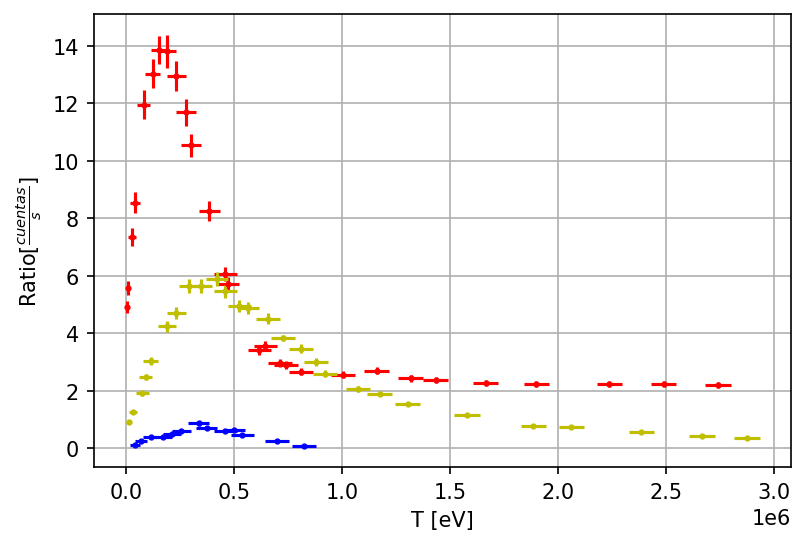

------------------------------------------------ACTIVIDAD INCIAL MUESTRAS UTILIZADAS----------------------------

Actividad Kripton= 12719.942797355201
Error actividad Kripton= 204.8511265536836
-----------------------------------
Actividad Radio= 3273.303051525377
Error actividad Radio= 0.35451262207548134
-----------------------------------
Actividad Sodio= 53311.558111514154
Error actividad Sodio= 1179.645678572715
-----------------------------------
Actividad Estroncio= 15993.781281797324
Error actividad Estroncio= 98.28053547845961
-----------------------------------
---------------------------------------------------------------------------------------------------


In [66]:
#Pasemos ahora al cálculo de las tasas reales en cada uno de los elementos radiactivos:



##############################            ESTRONCIO          ########################################
A_0_Sr = 40700
T_vm_Sr = 28.2
intervalo_Sr = 38.00
s_intervalo_Sr = 0.25

A_Sr = actividad(A_0_Sr,intervalo_Sr,T_vm_Sr)
s_A_Sr = error_actividad(A_0_Sr,intervalo_Sr,T_vm_Sr,s_intervalo_Sr)


##############################             KRYPTON           ########################################

#Actividad e incertidumbre de la muestra:
A_Kr = actividad(A_0_Kr,intervalo_Kr,T_vm_Kr)
s_A_Kr = error_actividad(A_0_Kr,intervalo_Kr,T_vm_Kr,s_intervalo_Kr)

#Incertidumbres asociada a N_kr:
s_N_kr = error_cuentas(N_kr)

#Tasa junto con su incertidumbre  asociada a Kr:
R_kr = tasa_desintegracion(N_kr,t_kr)
s_R_kr = error_tasa_desintegracion(N_kr,t_kr,s_N_kr,s_T)

#Corrijo la tasa con la tasa de radiación de fondo:
R_kr_corregida = tasa_corregida(R_kr,R_f)
s_R_kr_corregida =error_tasa_corregida(R_kr,R_f,s_R_kr,s_R_f)

#Obtengo la tasa real asociada a Kr:
R_kr_real = tasa_real(R_kr_corregida,tiempo_muerto)
s_R_kr_real = error_tasa_real(R_kr_corregida,tiempo_muerto,s_R_kr_corregida,s_tiempo_muerto)

#Calcularemos ahora las energías cinéticas y momentos para el Krypton a partir del campo magnético
T_kr = energia_cinetica(mB_kr,r,m)
s_T_kr = error_energia_cinetica(mB_kr,r,m,s_B)

p_kr = momento_lineal(mB_kr,r) # [eVs/m]
s_p_kr = error_momento_lineal(r,s_B)

F_kr = Fermi(37,85,p_kr,1)
eta_kr = eta(-1,37,p_kr)
s_eta_kr = s_eta(1,37,p_kr,s_p_kr)

s_F_kr = error_Fermi(F_kr,eta_kr,s_eta_kr)

s_Kr = np.sqrt((p_kr)**2 + ((0.687e6 - T_kr)/3e8)**2)

s_s_Kr = np.sqrt(  ((2*p_kr)**2)*(s_p_kr**2)   + ((2*(0.687e6 - T_kr)  /  ((3e8)**2)  )**2)*(s_T_kr**2)   )

FK_kr = Fermi_Kurie(R_kr_real,p_kr,F_kr,s_Kr)

s_FK_kr = error_Fermi_kurie(R_kr_real,p_kr,F_kr,s_Kr,s_R_kr_real,s_p_kr,s_F_kr,s_s_Kr)


##############################               RADIO          ########################################


#Actividad e incertidumbre de la muestra:
A_Ra = actividad(A_0_Ra,intervalo_Ra,T_vm_Ra)
s_A_Ra = error_actividad(A_0_Ra,intervalo_Ra,T_vm_Ra,s_intervalo_Ra)


#Incertidumbres asociada a N_ra:
s_N_ra = error_cuentas(N_ra)

#Tasa junto con su incertidumbre  asociada a Ra:
R_ra = tasa_desintegracion(N_ra,t_ra)
s_R_ra = error_tasa_desintegracion(N_ra,t_ra,s_N_ra,s_T)

#Corrijo la tasa con la tasa de radiación de fondo:
R_ra_corregida = tasa_corregida(R_ra,R_f)
s_R_ra_corregida =error_tasa_corregida(R_ra,R_f,s_R_ra,s_R_f)

#Obtengo la tasa real asociada a Ra:
R_ra_real = tasa_real(R_ra_corregida,tiempo_muerto)
s_R_ra_real = error_tasa_real(R_ra_corregida,tiempo_muerto,s_R_ra_corregida,s_tiempo_muerto)

#Calcularemos ahora la energía cinética y momento para el Radio a partir del campo magnético
T_ra = energia_cinetica(mB_ra,r,m)
s_T_ra = error_energia_cinetica(mB_ra,r,m,s_B)

p_ra = momento_lineal(mB_ra,r)
s_p_ra = error_momento_lineal(r,s_B)

F_ra_1 = Fermi(83,214,p_ra,1)
F_ra_2 = Fermi(84,214,p_ra,1)
F_ra_3 = Fermi(83,210,p_ra,1)
F_ra_4 = Fermi(84,210,p_ra,1)


##############################              SODIO           ########################################


#Actividad e incertidumbre de la muestra:
A_Na = actividad(A_0_Na,intervalo_Na,T_vm_Na)
s_A_Na = error_actividad(A_0_Na,intervalo_Na,T_vm_Na,s_intervalo_Na)


#Incertidumbres asociada a N_na:
s_N_na = error_cuentas(N_na)

#Tasa junto con su incertidumbre  asociada a Na:
R_na = tasa_desintegracion(N_na,t_na)
s_R_na = error_tasa_desintegracion(N_na,t_na,s_N_na,s_T)

#Corrijo la tasa con la tasa de radiación de fondo:
R_na_corregida = tasa_corregida(R_na,R_f)
s_R_na_corregida =error_tasa_corregida(R_na,R_f,s_R_na,s_R_f)

#Obtengo la tasa real asociada a Na:
R_na_real = tasa_real(R_na_corregida,tiempo_muerto)
s_R_na_real = error_tasa_real(R_na_corregida,tiempo_muerto,s_R_na_corregida,s_tiempo_muerto)

#Calcularemos ahora la energía cinética y momento para el Sodio a partir del campo magnético
T_na = energia_cinetica(mB_na,r,m)
s_T_na = error_energia_cinetica(mB_na,r,m,s_B)

p_na = momento_lineal(mB_na,r)
s_p_na = error_momento_lineal(r,s_B)

F_na = Fermi(10,22,p_na,-1)
eta_na = eta(-1,10,p_na)
s_eta_na = s_eta(-1,10,p_na,s_p_na)
s_F_na = error_Fermi(F_na,eta_na,s_eta_na)






FK_na = Fermi_Kurie(R_na_real,p_na,F_na,1)
s_FK_na = error_Fermi_kurie(R_na_real,p_na,F_na,1,s_R_na_real,s_p_na,s_F_na,0)

####################################################################################################
#ploteamos tasa de cuentas real frente a T

plt.errorbar(T_na,R_na_real, yerr=s_R_na_real, xerr=s_T_na, ms=2, c='r', fmt='o')
plt.errorbar(T_ra,R_ra_real, yerr=s_R_ra_real, xerr=s_T_ra, ms=2, c='y', fmt='o')
plt.errorbar(T_kr,R_kr_real, yerr=s_R_kr_real, xerr=s_T_kr, ms=2, c='b', fmt='o')
plt.xlabel('T [eV]')
plt.ylabel('Ratio[$\\frac{cuentas}{s}$]')
plt.grid()
plt.savefig('espectros.png')
plt.show()
####################################################################################################

print('------------------------------------------------ACTIVIDAD INCIAL MUESTRAS UTILIZADAS----------------------------')
print('')
print('Actividad Kripton=', A_Kr)
print('Error actividad Kripton=', s_A_Kr)
print('-----------------------------------')
print('Actividad Radio=', A_Ra)
print('Error actividad Radio=', s_A_Ra)
print('-----------------------------------')
print('Actividad Sodio=', A_Na)
print('Error actividad Sodio=', s_A_Na)
print('-----------------------------------')
print('Actividad Estroncio=', A_Sr)
print('Error actividad Estroncio=', s_A_Sr)
print('-----------------------------------')



print('---------------------------------------------------------------------------------------------------')


# ANALISIS DE LOS ESPECTROS DE LAS FUENTE RADIACTIVAS

# SODIO-22

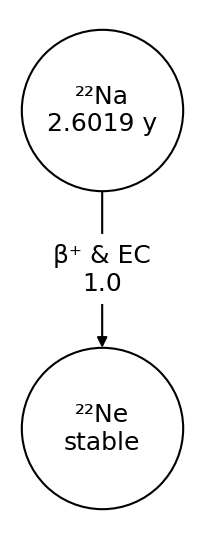

In [67]:
nuc = rd.Nuclide('NA-22')
fig, ax = nuc.plot(label_pos=0.5)
fig.savefig('Na-22.png', dpi=150)

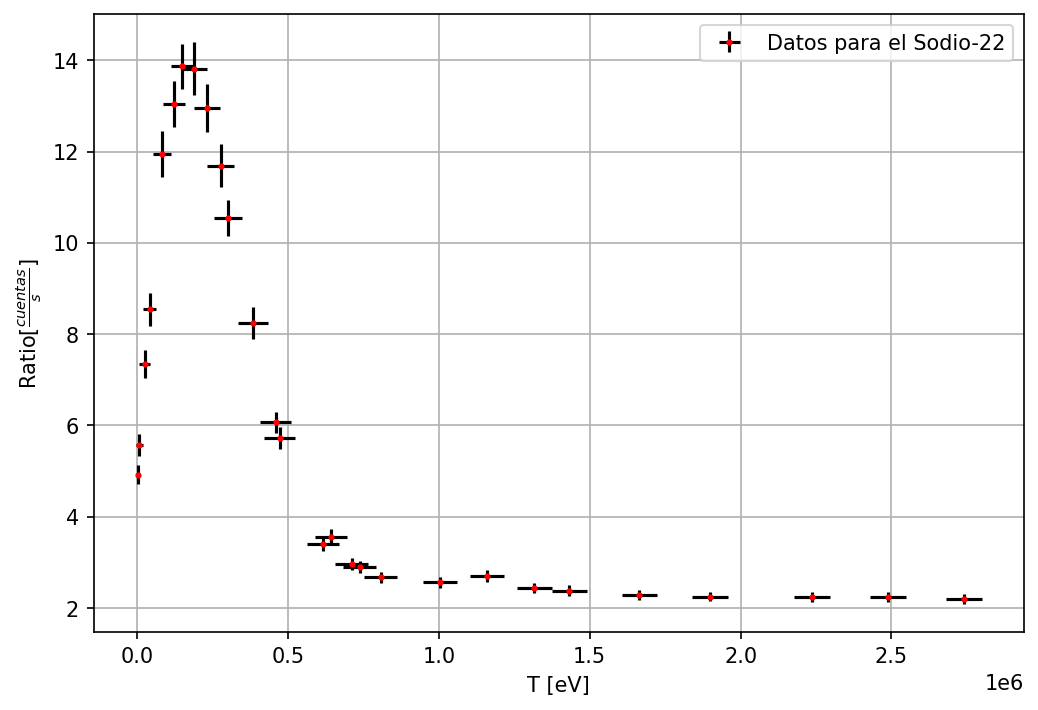

In [68]:
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.errorbar(T_na,R_na_real, yerr=s_R_na_real, xerr=s_T_na, fmt='or', ms=2, ecolor='black', label='Datos para el Sodio-22')
plt.xlabel('T [eV]')
plt.ylabel('Ratio[$\\frac{cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('ratio_na.png')
plt.show()

----------------------------------------------------------------------------------------------------------------
Q_value_na = 0.5822806228141523 [MeV] -->s(Q_value_na)= 0.02291457624428586 [MeV]
a = 155.10257303549005 --> s(a)= 10.591605733704785
chi_na_1= 747.8265560035535
----------------------------------------------------------------------------------------------------------------


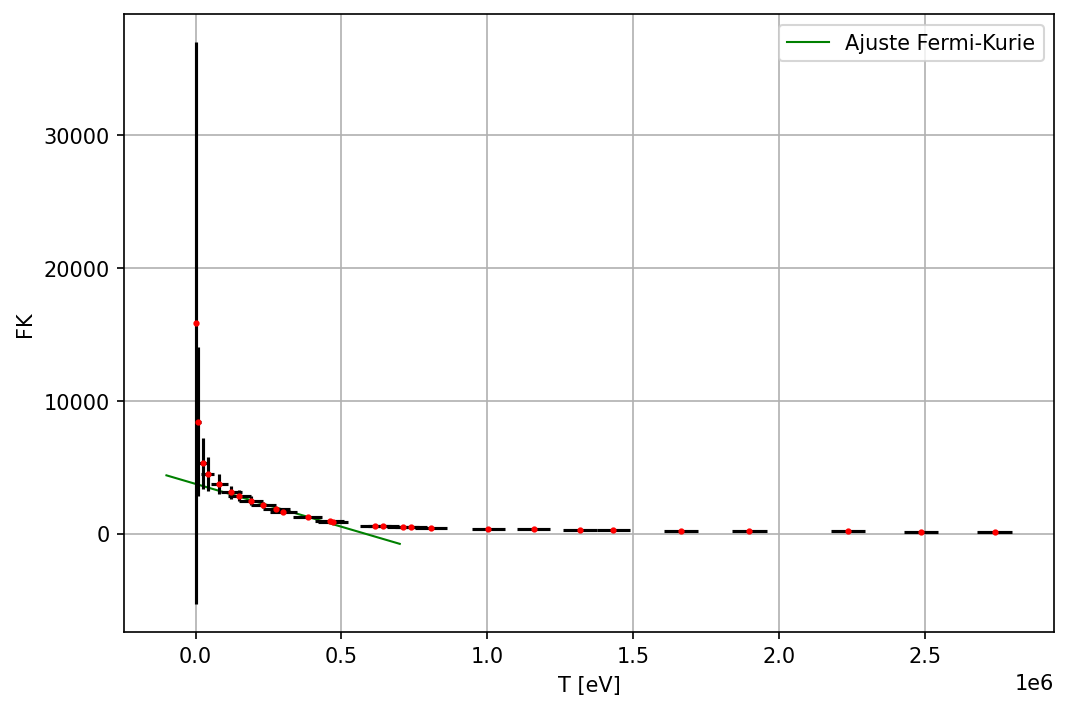

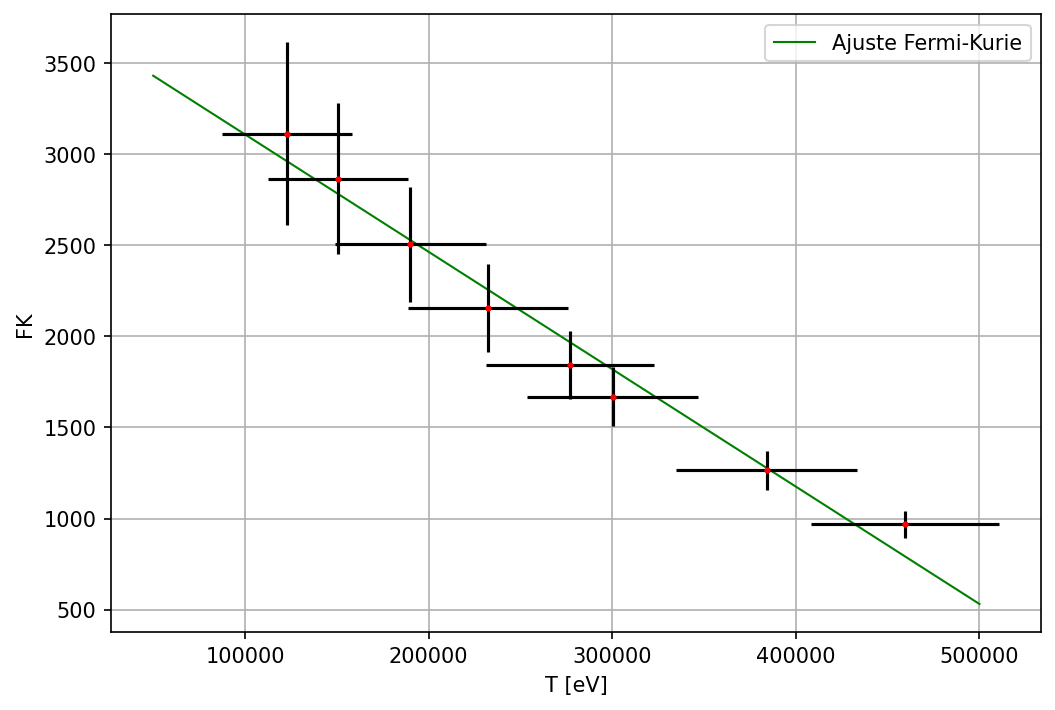

--------------------------------------------------------------------------------------------------------------
Q_value_na = 0.5712103800341328 [MeV] -->s(Q_value_na)= 0.01439268537299833 [MeV]
a = 3.053449300110742e-05 --> s(a)= 2.9851261229591108e-06
chi_na_2= 68.91057226338938
grados de libertad = 14
--------------------------------------------------------------------------------------------------------------


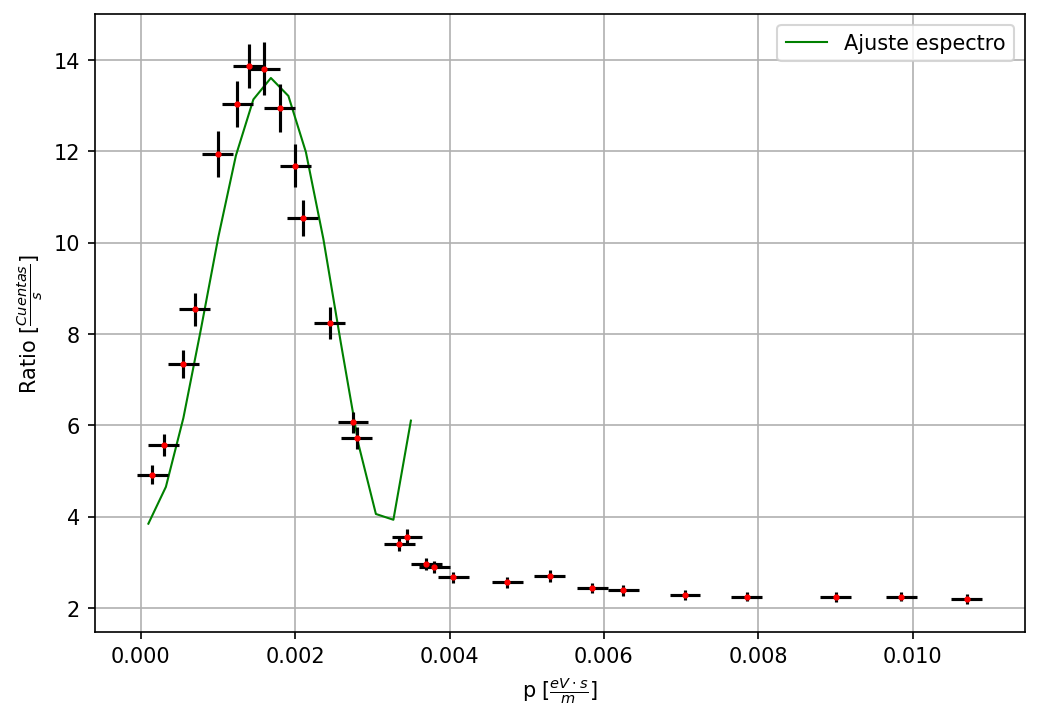

In [69]:
######################################################################################################################

#Puesto que la desintegración más probable del Sodio es permitida el Shape factor S=1

#Vamos a tomar los valores a partir de 80 [KeV] ya que a bajas energías nos alejamos de la linealidad y acotamos por debajo de 500 [KeV]

#a partir de 80 [keV]
T_na_lineal_1=(T_na>=8.15547765e+04)
FK_na_lineal_1=(FK_na<=3722.63824365)


T_na_lineal_2=T_na[T_na_lineal_1]
FK_na_lineal_2=FK_na[FK_na_lineal_1]

#por debajo de 500 [keV]
T_na_lineal_3=(T_na_lineal_2<4.72220191e+05)
FK_na_lineal_3=(FK_na_lineal_2>922.75716813)


T_na_lineal=T_na_lineal_2[T_na_lineal_3]
s_T_na_lineal = [35498.27829547, 38097.94903684, 41079.19273218, 43580.52211695, 45678.80686852, 46598.5346721,  49263.90450249, 51008.02902005]
FK_na_lineal=FK_na_lineal_2[FK_na_lineal_3]
s_FK_na_lineal = [5.01750590e+02, 4.12637001e+02, 3.17415058e+02, 2.43575644e+02, 1.88124528e+02, 1.61830317e+02, 1.06776923e+02, 7.27876379e+01]
######################################################################################################################
######################################################################################################################


R_na_fermi=R_na_real[0:16]
s_R_na_real_fermi = s_R_na_real[0:16]
F_na_fermi=F_na[0:16]
p_na_fermi=p_na[0:16]
T_na_fermi=T_na[0:16]


######################################################################################################################
#############################################  AJUSTE_1 A ECUACION LINEAL   ########################################## 
######################################################################################################################

popt, pcov = curve_fit(ajuste_fermi_kurie, T_na_lineal, FK_na_lineal)
perr = np.sqrt(np.diag(pcov))
Q_value_na = popt[0]
s_Q_value_na = perr[0]
a = popt[1]
s_a = perr[1]

parametros_na = [Q_value_na, a]

#El chi del ajuste:
y_chi_na_1=ajuste_fermi_kurie(T_na_lineal,*parametros_na)
Chi_na_1 = chi2(FK_na_lineal,y_chi_na_1,s_FK_na_lineal)

print('----------------------------------------------------------------------------------------------------------------')
print('Q_value_na =',Q_value_na/1e6, '[MeV]','-->s(Q_value_na)=', s_Q_value_na/1e6,'[MeV]')
print('a =',a ,'--> s(a)=',s_a)
print('chi_na_1=',Chi_na_1)
print('----------------------------------------------------------------------------------------------------------------')

######################################################################################################################
##########################################           REPRESENTO              #########################################
######################################################################################################################

x_FK_na =  np.linspace(-0.1e6, 0.7e6, 10)
y_FK_na = ajuste_fermi_kurie(x_FK_na,*parametros_na)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_FK_na, y_FK_na, c='g', linewidth= 1, label='Ajuste Fermi-Kurie')
ax1.errorbar(T_na, FK_na, xerr=s_T_na, yerr=s_FK_na, fmt='or', ms=2, ecolor='black')

plt.xlabel('T [eV]')
plt.ylabel('FK')
plt.grid()
plt.legend()
plt.savefig('espectroFK_na.png')
plt.show()

######################################################################################################################
###########################################            ZONA LINEAL           #########################################
######################################################################################################################

x_FK_na =  np.linspace(0.05e6, 0.5e6, 10)
y_FK_na = ajuste_fermi_kurie(x_FK_na,*parametros_na)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_FK_na, y_FK_na, c='g', linewidth= 1, label='Ajuste Fermi-Kurie')
ax1.errorbar(T_na_lineal, FK_na_lineal, xerr=s_T_na_lineal, yerr=s_FK_na_lineal, fmt='or', ms=2, ecolor='black')

plt.xlabel('T [eV]')
plt.ylabel('FK')
plt.grid()
plt.legend()
plt.savefig('espectro_na_lineal.png')
plt.show()


######################################################################################################################
########################################  AJUSTE_2 A ECUACION CUADRÁTICA   ###########################################
######################################################################################################################

def ajuste_cuadratico_fermi(x,a,b):
    return 3.76 + a*((x)**2)*((b-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_na_fermi

popt,pcov = curve_fit(ajuste_cuadratico_fermi,p_na_fermi,R_na_fermi)
perr = np.sqrt(np.diag(pcov))



a_F = popt[0]#a
s_a_F = perr[0]
Q_value_na_F = popt[1]#b
s_Q_value_na_F = perr[1]
parametros_fermi_na = [a_F,Q_value_na_F]

#El chi del ajuste:

y_chi_na_2=ajuste_cuadratico_fermi(p_na_fermi,*parametros_fermi_na)

Chi_na_2 = chi2(R_na_fermi,y_chi_na_2,s_R_na_real_fermi)


print('--------------------------------------------------------------------------------------------------------------')
print('Q_value_na =',Q_value_na_F/1e6, '[MeV]','-->s(Q_value_na)=', s_Q_value_na_F/1e6,'[MeV]')
print('a =',a_F ,'--> s(a)=',s_a_F)
print('chi_na_2=',Chi_na_2)
print('grados de libertad =',len(R_na_fermi)-2)
print('--------------------------------------------------------------------------------------------------------------')

######################################################################################################################
##########################################             REPRESENTO               ######################################
######################################################################################################################

x_na = np.linspace(0.0001, 0.0035, 16)
y_na = ajuste_cuadratico_fermi(x_na, *parametros_fermi_na)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_na, y_na, c='g', linewidth= 1, label='Ajuste espectro')
ax1.errorbar(p_na, R_na_real, xerr=s_p_na, yerr=s_R_na_real, fmt='or', ms=2, ecolor='black')

plt.xlabel('p [$\\frac{eV\cdot s}{m}$]')
plt.ylabel('Ratio [$\\frac{Cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('espectroF_na.png')
plt.show()


######################################################################################################################
######################################################################################################################

# KRYPTON-85

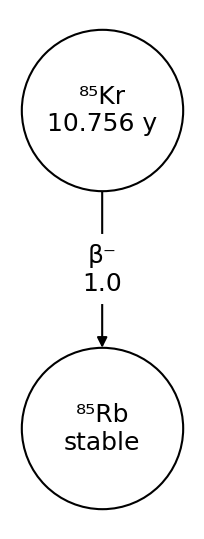

In [70]:

nuc = rd.Nuclide('KR-85')
fig, ax = nuc.plot(label_pos=0.5)
fig.savefig('Kr-85.png', dpi=150)

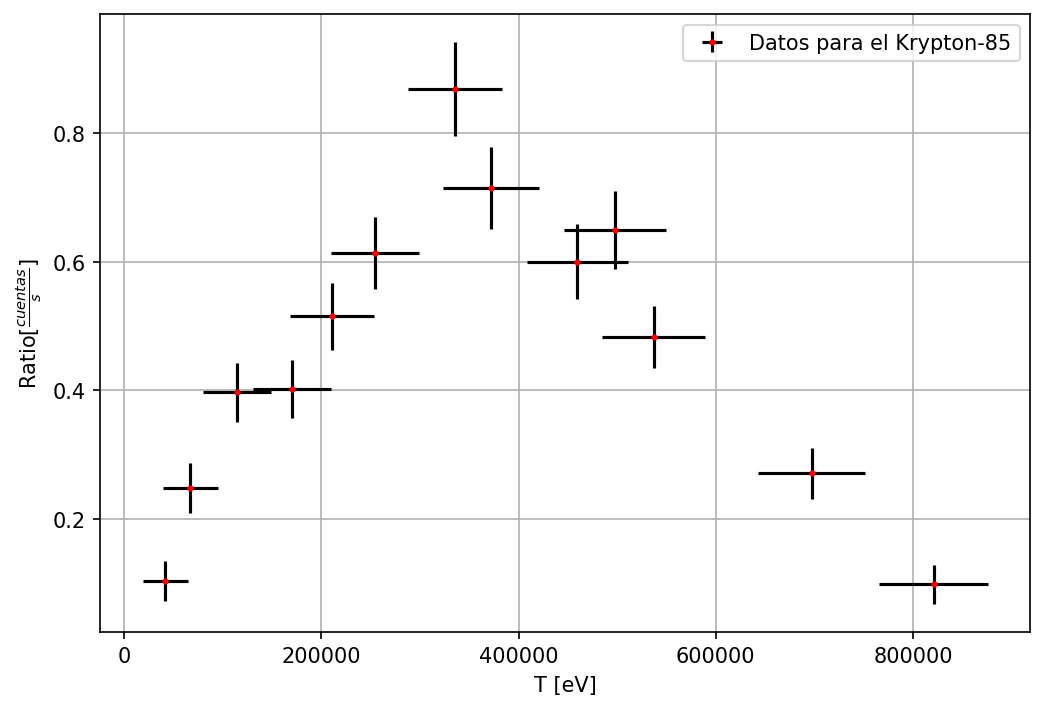

In [71]:
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.errorbar(T_kr,R_kr_real, yerr=s_R_kr_real, xerr=s_T_kr, fmt='or', ms=2, ecolor='black', label='Datos para el Krypton-85')
plt.xlabel('T [eV]')
plt.ylabel('Ratio[$\\frac{cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('ratio_kr.png')
plt.show()

----------------------------------------------------------------------------------------------------------------
Q-value 0.7587924089240959 MeV -->s(Q)= 0.03610793018992865
a = 18.192262479239645 --> s(a)= 2.007049883503809
grados de libertad = 3
chi_kr_1= 1884.150192656901
----------------------------------------------------------------------------------------------------------------


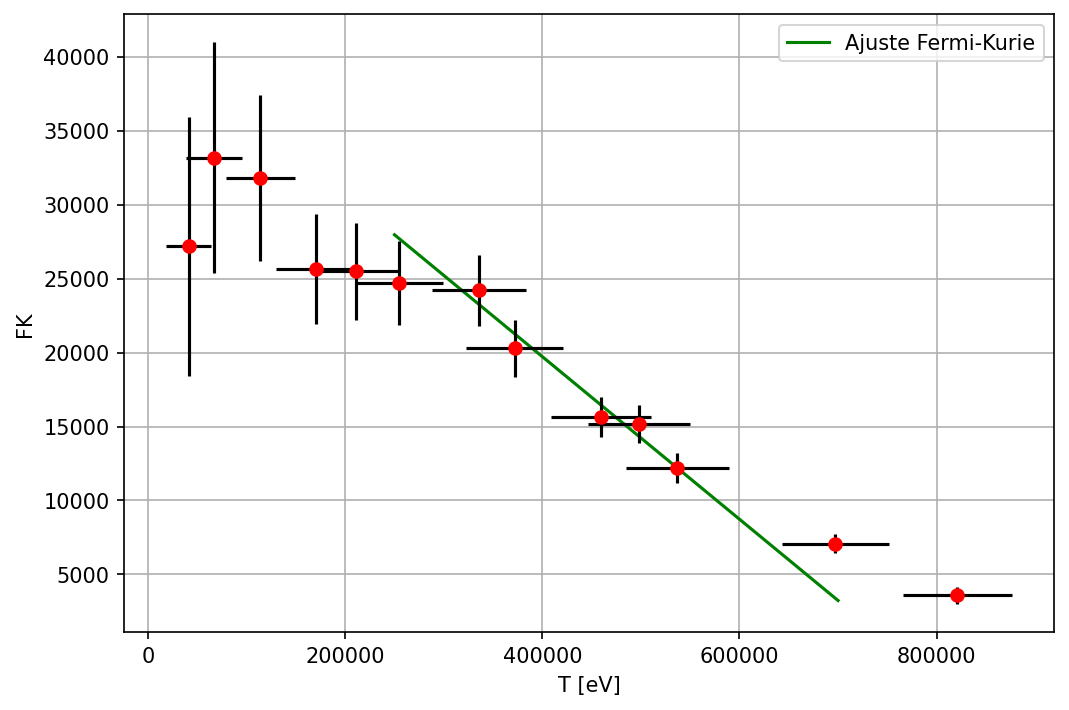

----------------------------------------------------------------------------------------------------------------
Q_value_kr = 0.7646531046187478 [MeV] -->s(Q_value_kr)= 0.02459122576640775 [MeV]
a = 0.5265765876925709 --> s(a)= 0.11622224663534125
z = 0.16220287579702397 --> s(z)= 0.06024071717973811
chi_kr_2= 2.8368707935475097
grados de libertad = 11
----------------------------------------------------------------------------------------------------------------


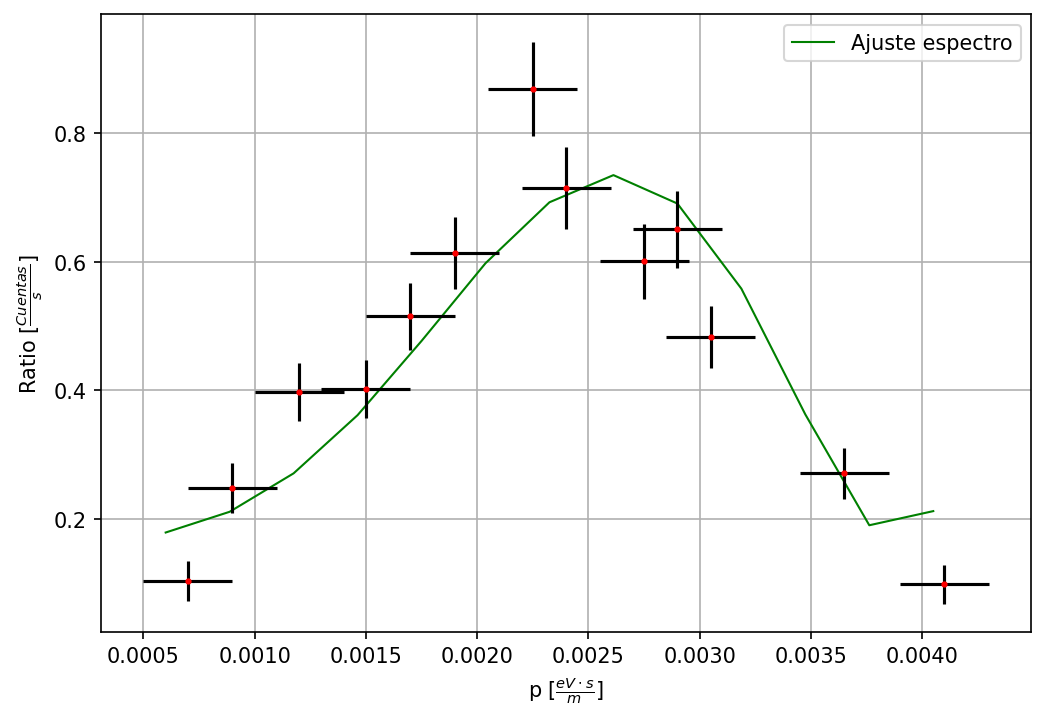

In [72]:
#####################################################################################################################

#Puesto que la desintegración más probable del Kripton es prohibida de primer orden el Shape factor S= p + q

#Vamos a tomar los valores a partir de 250 [KeV] ya que a bajas energías nos alejamos de la linealidad y acotamos 
#por debajo de 697 [KeV]


#a partir de 0.25 [MeV]
T_kr_lineal_1=(T_kr>254520.41712866)
p_kr_lineal_1=(p_kr>0.0019)
T_kr_lineal_2=T_kr[T_kr_lineal_1]
p_kr_lineal_2=p_kr[p_kr_lineal_1]

#por debajo de 0.7 [MeV]
T_kr_lineal_3=(T_kr_lineal_2<697365.58819389)
p_kr_lineal_3=(p_kr_lineal_2<0.00365)
p_kr_lineal = p_kr_lineal_2[p_kr_lineal_3]
T_kr_lineal = T_kr_lineal_2[T_kr_lineal_3]


R_kr_real_lineal = [0.86891896, 0.71480181, 0.60064455, 0.65034829, 0.48294841]

F_kr_lineal = Fermi(37,85,p_kr_lineal,1)

s_Kr_lineal = np.sqrt((p_kr_lineal)**2 + ((0.687e6 - T_kr_lineal)/3e8)**2)

FK_kr_lineal = Fermi_Kurie(R_kr_real_lineal,p_kr_lineal,F_kr_lineal,s_Kr_lineal)

s_FK_kr_lineal = [2378.26020703, 1920.3802423,  1364.78852443, 1261.88903211, 1006.33783693]
#####################################################################################################################
#########################################  AJUSTE_1 A ECUACION LINEAL   #############################################
#####################################################################################################################

popt, pcov = curve_fit(ajuste_fermi_kurie, T_kr_lineal, FK_kr_lineal)
perr = np.sqrt(np.diag(pcov))

Q_value_kr_F = popt[0]#b
s_Q_value_kr_F = perr[0]
a_F_kr = popt[1]#a
s_a_F_kr = perr[1]

parametros_kr = [Q_value_kr_F,a_F_kr]

#El chi del ajuste:
y_chi_kr_1=ajuste_fermi_kurie(T_kr_lineal,*parametros_kr)

Chi_kr_1 = chi2(FK_kr_lineal,y_chi_kr_1,s_FK_kr_lineal)


print('----------------------------------------------------------------------------------------------------------------')
print('Q-value',Q_value_kr_F/1e6, 'MeV','-->s(Q)=', s_Q_value_kr_F/1e6)
print('a =',a_F_kr ,'--> s(a)=',s_a_F_kr)
print('grados de libertad =',len(FK_kr_lineal)-2)
print('chi_kr_1=',Chi_kr_1)
print('----------------------------------------------------------------------------------------------------------------')

#####################################################################################################################
########################################           REPRESENTO               #########################################
#####################################################################################################################

x_FK_kr = np.linspace(0.25e6, 0.7e6, 128)
y_FK_kr = ajuste_fermi_kurie(x_FK_kr, *parametros_kr)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_FK_kr, y_FK_kr,c='g', label='Ajuste Fermi-Kurie')
ax1.errorbar(T_kr, FK_kr, xerr=s_T_kr, yerr=s_FK_kr, fmt='or', ecolor='black')

plt.xlabel('T [eV]')
plt.ylabel('FK')
plt.grid()
plt.legend()
plt.savefig('espectroFK_kr.png')
plt.show()

#####################################################################################################################
########################################  AJUSTE_2 A ECUACION CUADRÁTICA   ###########################################
#####################################################################################################################


def ajuste_cuadratico_fermi_kr(x,a,b,z):
    return z + a*((x)**2)*((b-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_kr*((x)**2 + ((b - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)

popt,pcov = curve_fit(ajuste_cuadratico_fermi_kr,p_kr,R_kr_real,bounds=(0,2e7))
perr = np.sqrt(np.diag(pcov))



a_kr = popt[0]#a
s_a_kr = perr[0]
Q_value_kr = popt[1]#b
s_Q_value_kr = perr[1]
z = popt[2]
s_z = perr[2]
parametros_fermi_kr = [a_kr,Q_value_kr,z]

#El chi del ajuste:

y_chi_kr_2=ajuste_cuadratico_fermi_kr(p_kr,*parametros_fermi_kr)

Chi_kr_2 = chi2(R_kr_real,y_chi_kr_2,s_R_kr_real)


print('----------------------------------------------------------------------------------------------------------------')
print('Q_value_kr =',Q_value_kr/1e6, '[MeV]','-->s(Q_value_kr)=', s_Q_value_kr/1e6,'[MeV]')
print('a =',a_kr ,'--> s(a)=',s_a_kr)
print('z =',z ,'--> s(z)=',s_z)

print('chi_kr_2=',Chi_kr_2)
print('grados de libertad =',len(R_kr_real)-2)
print('----------------------------------------------------------------------------------------------------------------')

#####################################################################################################################
########################################           REPRESENTO               #########################################
#####################################################################################################################

x_kr = np.linspace(0.0006, 0.00405, 13)
y_kr = ajuste_cuadratico_fermi_kr(x_kr, *parametros_fermi_kr)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_kr, y_kr, c='g', linewidth= 1, label='Ajuste espectro')
ax1.errorbar(p_kr, R_kr_real, xerr=s_p_kr, yerr=s_R_kr_real, fmt='or', ms=2, ecolor='black')

plt.xlabel('p [$\\frac{eV\cdot s}{m}$]')
plt.ylabel('Ratio [$\\frac{Cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('espectroF_kr.png')
plt.show()


#####################################################################################################################

In [73]:
print(s_FK_kr)

[8752.14167603 7807.92084734 5608.46518967 3706.04470564 3269.54010517
 2835.29665029 2378.26020703 1920.3802423  1364.78852443 1261.88903211
 1006.33783693  647.65398685  585.39959316]


# RADIO-226

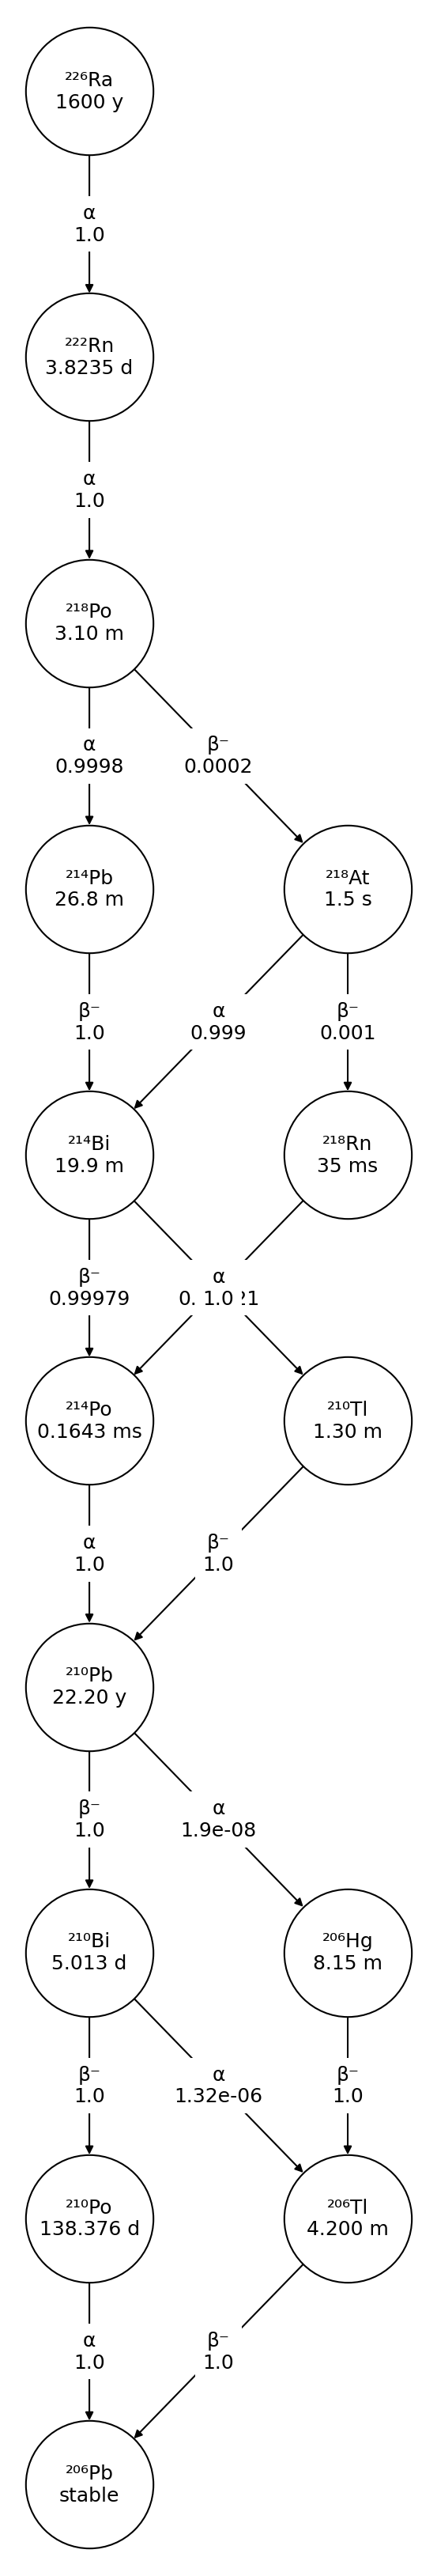

In [74]:
nuc = rd.Nuclide('RA-226')
fig, ax = nuc.plot(label_pos=0.5)
fig.savefig('Ra-222.png', dpi=150)

In [75]:
############################################   ACTIVIDAD RADIO    ###################################################

inv_t0 = rd.Inventory({'RA-226': 3330}, 'Bq')

inv_t1 = inv_t0.decay(39.64, 'y')

inv_t1.activities()

{'At-218': 0.6546648960433036,
 'Bi-210': 2338.8528285206753,
 'Bi-214': 3273.3240070865136,
 'Hg-206': 4.4449168684547776e-05,
 'Pb-206': 0.0,
 'Pb-210': 2339.4305826328773,
 'Pb-214': 3272.6699194486487,
 'Po-210': 2322.614481510752,
 'Po-214': 3272.6372637099316,
 'Po-218': 3273.3244801192727,
 'Ra-226': 3273.303051525377,
 'Rn-218': 0.0006546648960437574,
 'Rn-222': 3273.324468060938,
 'Tl-206': 0.0031317344522319673,
 'Tl-210': 0.687398042550079}

#### Calculo los pesos relativos para tener en cuenta en el ajuste del espectro

In [76]:
W_i = [0.29, 0.29, 0.21, 0.21]
print('W_i=',W_i)

W_i= [0.29, 0.29, 0.21, 0.21]


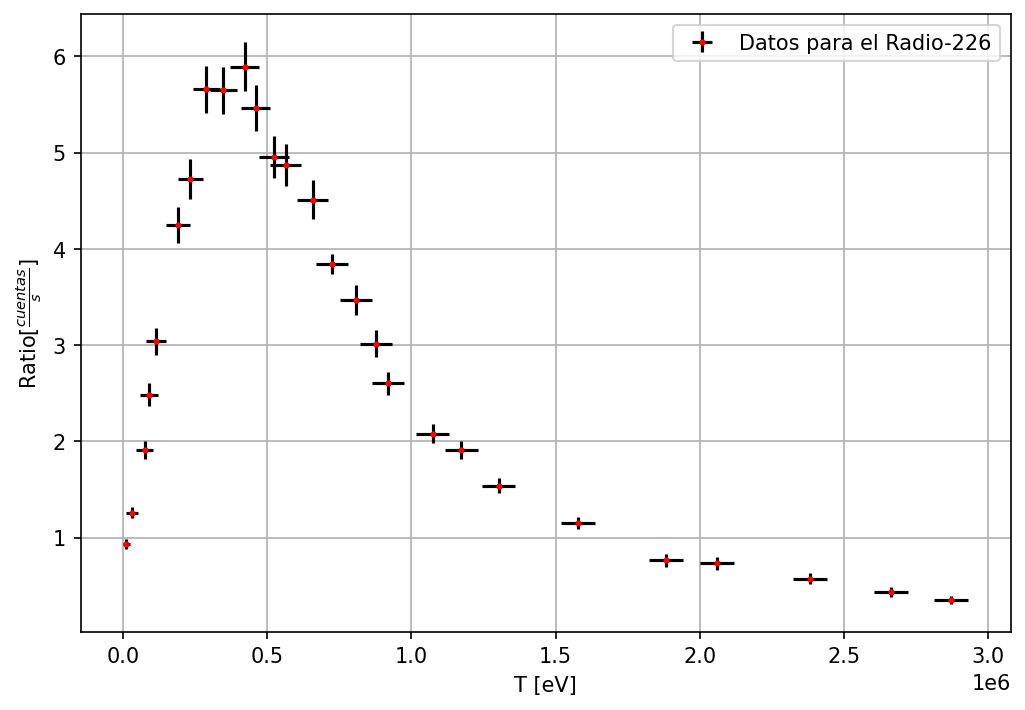

In [77]:
fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.errorbar(T_ra,R_ra_real, yerr=s_R_ra_real, xerr=s_T_ra, fmt='or', ms=2, ecolor='black', label='Datos para el Radio-226')
plt.xlabel('T [eV]')
plt.ylabel('Ratio[$\\frac{cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('ratio_ra.png')
plt.show()

-------------------------------------------------------------------------------------------------------------
a_1 = 25420.93676713887 --> s(a_1)= 1785.9448209569036
a_2 = 2039.6861206417475 --> s(a_2)= 75.75526289360845
a_3 = -10993.417182067273 --> s(a_3)= 702.7020529452249
a_4 = -46299.02860053461 --> s(a_4)= 3886.832771825642
-------------------------------------------------------------------------------------------------------------
chi_kr_2= 37.22721450058332
-------------------------------------------------------------------------------------------------------------


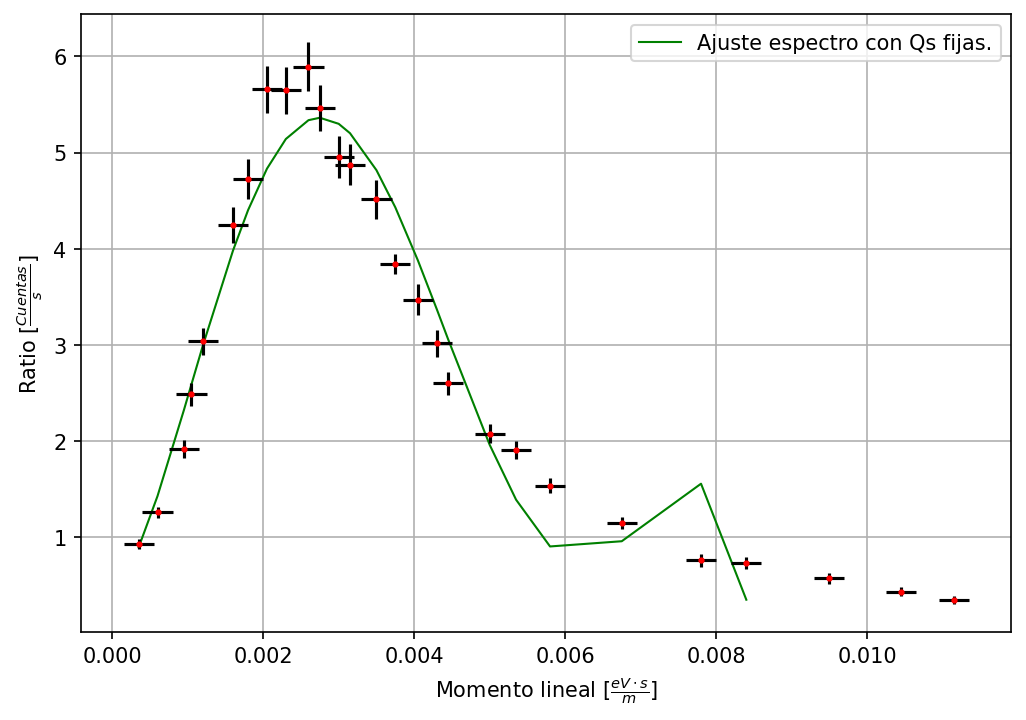

In [78]:
######################################################################################################################
####################################  AJUSTE_2 A ECUACION CUADRÁTICA FIJANDO Q's   ###################################
######################################################################################################################

R_ra_fermi=R_ra_real[0:24]
s_R_ra_fermi = s_R_ra_real[0:24]
F_ra_fermi_1=F_ra_1[0:24]
F_ra_fermi_2=F_ra_2[0:24]
F_ra_fermi_3=F_ra_3[0:24]
F_ra_fermi_4=F_ra_4[0:24]
p_ra_fermi=p_ra[0:24]
#s_p_ra_fermi = s_p_ra[0:15]
T_ra_fermi=T_ra[0:24]


def ajuste_cuadratico_fermi_ra(x,a1,a2,a3,a4):
    return 0.48 + ((x)**2)*( 0.29*a1*(((0.666e6-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_1*((x)**2 + ((0.666e6 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.29*a2*(((3.269e6-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_2*((x)**2 + ((3.269e6 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*a3*(((0.17e6-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_3*((x)**2 + ((0.17e6 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*a4*(((1.162e6-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_4*((x)**2 + ((1.162e6 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)))

popt,pcov = curve_fit(ajuste_cuadratico_fermi_ra,p_ra_fermi,R_ra_fermi, maxfev=10000000)
perr = np.sqrt(np.diag(pcov))




a_ra_1 = popt[0]
s_a_ra_1 = perr[0]
a_ra_2 = popt[1]
s_a_ra_2 = perr[1]
a_ra_3 = popt[2]
s_a_ra_3 = perr[2]
a_ra_4 = popt[3]
s_a_ra_4 = perr[3]


parametros_fermi_ra = [a_ra_1,a_ra_2,a_ra_3,a_ra_4]

#El chi del ajuste:

y_chi_ra=ajuste_cuadratico_fermi_ra(p_ra_fermi,*parametros_fermi_ra)

Chi_ra_2 = chi2(R_ra_fermi,y_chi_ra,s_R_ra_fermi)


print('-------------------------------------------------------------------------------------------------------------')
print('a_1 =',a_ra_1,'--> s(a_1)=',s_a_ra_1)
print('a_2 =',a_ra_2,'--> s(a_2)=',s_a_ra_2)
print('a_3 =',a_ra_3,'--> s(a_3)=',s_a_ra_3)
print('a_4 =',a_ra_4,'--> s(a_4)=',s_a_ra_4)
print('-------------------------------------------------------------------------------------------------------------')
print('chi_kr_2=',Chi_ra_2)
print('-------------------------------------------------------------------------------------------------------------')

######################################################################################################################
########################################           REPRESENTO               ##########################################
######################################################################################################################

x_ra = np.linspace(0.0001, 0.0055, 24)
y_ra = ajuste_cuadratico_fermi_ra(p_ra_fermi, *parametros_fermi_ra)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(p_ra_fermi, y_ra, c='g', linewidth= 1, label='Ajuste espectro con Qs fijas.')
ax1.errorbar(p_ra, R_ra_real, xerr=s_p_ra, yerr=s_R_ra_real, fmt='or', ms=2, ecolor='black')



plt.xlabel('Momento lineal [$\\frac{eV\cdot s}{m}$]')
plt.ylabel('Ratio [$\\frac{Cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('espectroF_ra_Q_fija.png')
plt.show()

######################################################################################################################
######################################################################################################################

-------------------------------------------------------------------------------------------------------------
Q_value_ra_1 = 0.5736089661939604 [MeV] -->s(Q_value_ra_1)= 0.10703397632898522 [MeV]
Q_value_ra_2 = 3.2886420475052507 [MeV] -->s(Q_value_ra_2)= 0.03106364408059672 [MeV]
Q_value_ra_3 = 0.0679824558167214 [MeV] -->s(Q_value_ra_3)= 0.11902759240159282 [MeV]
Q_value_ra_4 = 1.0828116698340815 [MeV] -->s(Q_value_ra_4)= 0.09120218255822114 [MeV]
-------------------------------------------------------------------------------------------------------------
chi_kr_2= 40.200731145857176
-------------------------------------------------------------------------------------------------------------


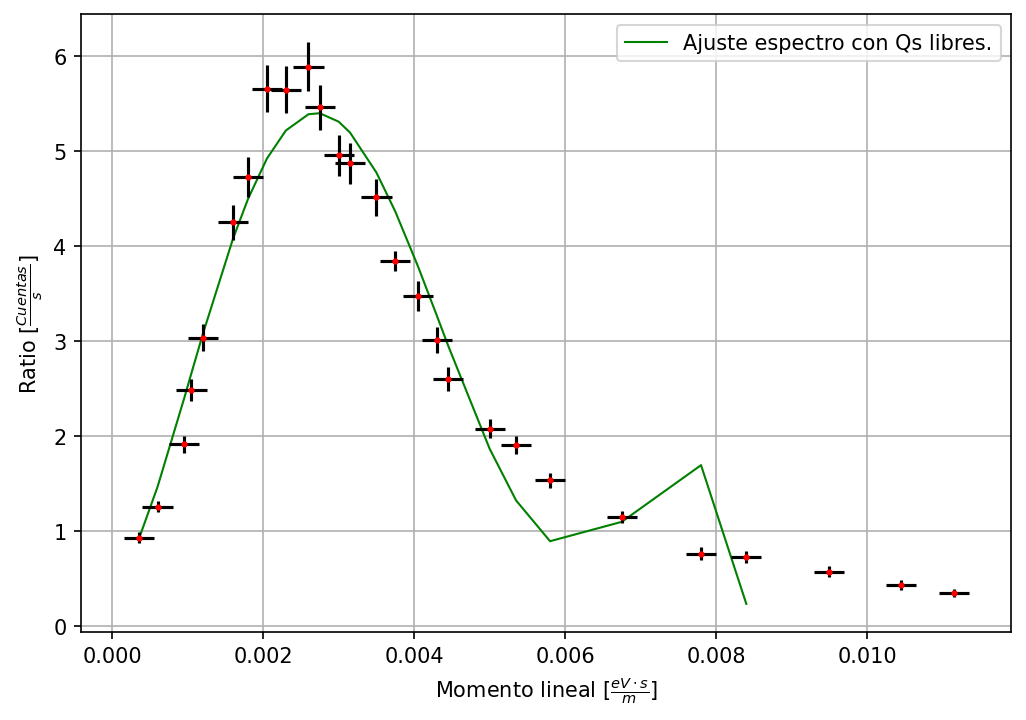

In [79]:
######################################################################################################################
########################################  AJUSTE_2 A ECUACION CUADRÁTICA Q's libres  #################################
######################################################################################################################


def ajuste_cuadratico_fermi_ra_Q_libre(x,b1,b2,b3,b4):
    return 0.48 + ((x)**2)*( 0.29*25420.937*(((b1-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_1*((x)**2 + ((b1 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.29*2039.686*(((b2-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_2*((x)**2 + ((b2 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*(-10993.417)*(((b3-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_3*((x)**2 + ((b3 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*(-46299.029)*(((b4-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_4*((x)**2 + ((b4 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)))

popt,pcov = curve_fit(ajuste_cuadratico_fermi_ra_Q_libre,p_ra_fermi,R_ra_fermi, maxfev=10000000,bounds=([0.5e6,2e6,0.05e6,0.5e6],[0.8e6,4e6,0.3e6,1.4e6]))
perr = np.sqrt(np.diag(pcov))


Q_value_ra_1 = popt[0]
s_Q_value_ra_1 = perr[0]
Q_value_ra_2 = popt[1]
s_Q_value_ra_2 = perr[1]
Q_value_ra_3 = popt[2]
s_Q_value_ra_3 = perr[2]
Q_value_ra_4 = popt[3]
s_Q_value_ra_4 = perr[3]

parametros_fermi_ra_Q_libre = [Q_value_ra_1, Q_value_ra_2, Q_value_ra_3, Q_value_ra_4]

#El chi del ajuste:

y_chi_ra_Q_libre=ajuste_cuadratico_fermi_ra_Q_libre(p_ra_fermi,*parametros_fermi_ra_Q_libre)

Chi_ra_2_Q_libre = chi2(R_ra_fermi,y_chi_ra_Q_libre,s_R_ra_fermi)


print('-------------------------------------------------------------------------------------------------------------')
print('Q_value_ra_1 =',Q_value_ra_1/1e6, '[MeV]','-->s(Q_value_ra_1)=', s_Q_value_ra_1/1e6,'[MeV]')
print('Q_value_ra_2 =',Q_value_ra_2/1e6, '[MeV]','-->s(Q_value_ra_2)=', s_Q_value_ra_2/1e6,'[MeV]')
print('Q_value_ra_3 =',Q_value_ra_3/1e6, '[MeV]','-->s(Q_value_ra_3)=', s_Q_value_ra_3/1e6,'[MeV]')
print('Q_value_ra_4 =',Q_value_ra_4/1e6, '[MeV]','-->s(Q_value_ra_4)=', s_Q_value_ra_4/1e6,'[MeV]')
print('-------------------------------------------------------------------------------------------------------------')
print('chi_kr_2=',Chi_ra_2_Q_libre)
print('-------------------------------------------------------------------------------------------------------------')

######################################################################################################################
########################################           REPRESENTO               ##########################################
######################################################################################################################


x_ra_Q_libre = np.linspace(0.0001, 0.0055, 24)
y_ra_Q_libre = ajuste_cuadratico_fermi_ra_Q_libre(p_ra_fermi, *parametros_fermi_ra_Q_libre)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(p_ra_fermi, y_ra_Q_libre, c='g', linewidth= 1, label='Ajuste espectro con Qs libres.')
ax1.errorbar(p_ra, R_ra_real, xerr=s_p_ra, yerr=s_R_ra_real, fmt='or', ms=2, ecolor='black')



plt.xlabel('Momento lineal [$\\frac{eV\cdot s}{m}$]')
plt.ylabel('Ratio [$\\frac{Cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('espectroF_ra_Q_libre.png')
plt.show()

######################################################################################################################
######################################################################################################################

-------------------------------------------------------------------------------------------------------------
a_1 = 1879457.6795118686 --> s(a_1)= 238522991.9679527
a_2 = 1050.266965367736 --> s(a_2)= 1404600.8164753078
a_3 = -65589.63077264825 --> s(a_3)= 348680802.5491624
a_4 = -3603955.3018364324 --> s(a_4)= 31862030.513714153
Q_value_ra_1 = 0.5615891299300456 [MeV] -->s(Q_value_ra_1)= 18.342955125291606 [MeV]
Q_value_ra_2 = 3.999993134159369 [MeV] -->s(Q_value_ra_2)= 1219.0965117785918 [MeV]
Q_value_ra_3 = 0.11330465576232021 [MeV] -->s(Q_value_ra_3)= 1092.4266896664362 [MeV]
Q_value_ra_4 = 0.5839455989285529 [MeV] -->s(Q_value_ra_4)= 21.882509155401458 [MeV]
-------------------------------------------------------------------------------------------------------------
chi_kr_2= 9.914675509545663
-------------------------------------------------------------------------------------------------------------


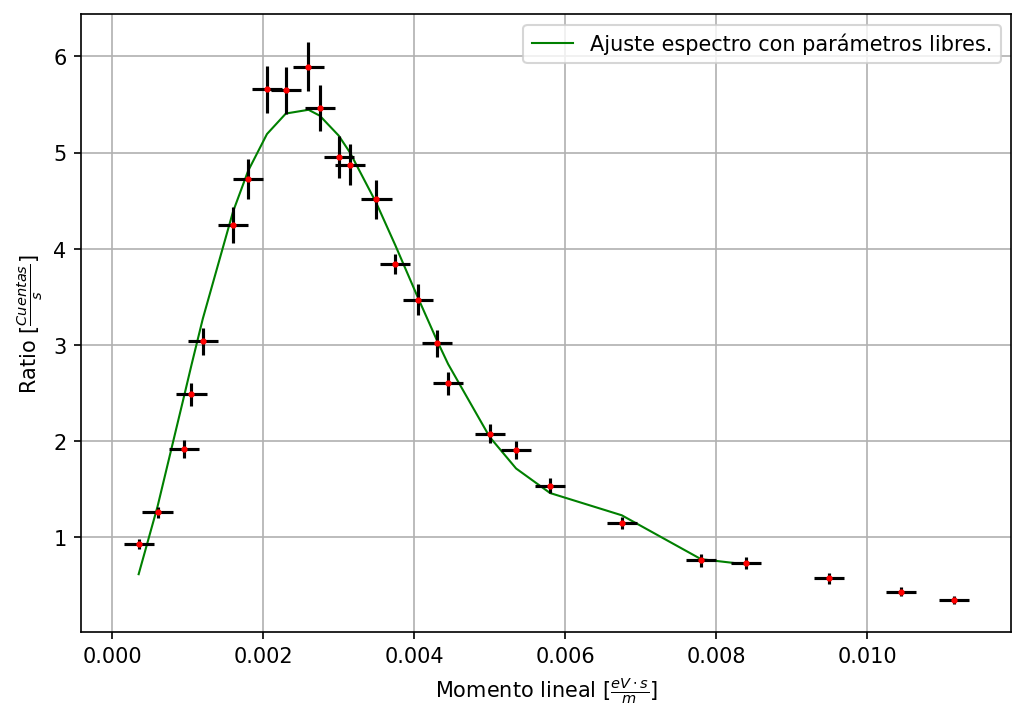

In [80]:
######################################################################################################################
################################  AJUSTE_2 A ECUACION CUADRÁTICA TÉRMINOS LIBRES   ###################################
######################################################################################################################


def ajuste_cuadratico_fermi_ra_libre(x,b1,b2,b3,b4,a1,a2,a3,a4):
    return 0.065 + ((x)**2)*( 0.29*a1*(((b1-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_1*((x)**2 + ((b1 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.29*a2*(((b2-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_2*((x)**2 + ((b2 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*a3*(((b3-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_3*((x)**2 + ((b3 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)) +
                    0.21*a4*(((b4-np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6)**2)*F_ra_fermi_4*((x)**2 + ((b4 - (np.sqrt((x*3e8)**2 +((0.511e6)**2))+0.511e6))/3e8)**2)))


popt,pcov = curve_fit(ajuste_cuadratico_fermi_ra_libre,p_ra_fermi,R_ra_fermi, maxfev=10000000,bounds=([0.5e6,2e6,0.05e6,0.5e6,-np.inf,-np.inf,-np.inf,-np.inf],[0.8e6,4e6,0.3e6,1.4e6,np.inf,np.inf,np.inf,np.inf]))
perr = np.sqrt(np.diag(pcov))



Q_value_ra_1_libre = popt[0]#b
s_Q_value_ra_1_libre = perr[0]
Q_value_ra_2_libre = popt[1]#b
s_Q_value_ra_2_libre = perr[1]
Q_value_ra_3_libre = popt[2]#b
s_Q_value_ra_3_libre = perr[2]
Q_value_ra_4_libre = popt[3]#b
s_Q_value_ra_4_libre = perr[3]


a_ra_1_libre = popt[4]
s_a_ra_1_libre = perr[4]
a_ra_2_libre = popt[5]
s_a_ra_2_libre = perr[5]
a_ra_3_libre = popt[6]
s_a_ra_3_libre = perr[6]
a_ra_4_libre = popt[7]
s_a_ra_4_libre = perr[7]


parametros_fermi_ra_libre = [Q_value_ra_1_libre, Q_value_ra_2_libre, Q_value_ra_3_libre, Q_value_ra_4_libre,a_ra_1_libre,a_ra_2_libre,a_ra_3_libre,a_ra_4_libre]

#El chi del ajuste:

y_chi_ra_libre=ajuste_cuadratico_fermi_ra_libre(p_ra_fermi,*parametros_fermi_ra_libre)

Chi_ra_2_libre = chi2(R_ra_fermi,y_chi_ra_libre,s_R_ra_fermi)


print('-------------------------------------------------------------------------------------------------------------')
print('a_1 =',a_ra_1_libre,'--> s(a_1)=',s_a_ra_1_libre)
print('a_2 =',a_ra_2_libre,'--> s(a_2)=',s_a_ra_2_libre)
print('a_3 =',a_ra_3_libre,'--> s(a_3)=',s_a_ra_3_libre)
print('a_4 =',a_ra_4_libre,'--> s(a_4)=',s_a_ra_4_libre)
print('Q_value_ra_1 =',Q_value_ra_1_libre/1e6, '[MeV]','-->s(Q_value_ra_1)=', s_Q_value_ra_1_libre/1e6,'[MeV]')
print('Q_value_ra_2 =',Q_value_ra_2_libre/1e6, '[MeV]','-->s(Q_value_ra_2)=', s_Q_value_ra_2_libre/1e6,'[MeV]')
print('Q_value_ra_3 =',Q_value_ra_3_libre/1e6, '[MeV]','-->s(Q_value_ra_3)=', s_Q_value_ra_3_libre/1e6,'[MeV]')
print('Q_value_ra_4 =',Q_value_ra_4_libre/1e6, '[MeV]','-->s(Q_value_ra_4)=', s_Q_value_ra_4_libre/1e6,'[MeV]')
print('-------------------------------------------------------------------------------------------------------------')
print('chi_kr_2=',Chi_ra_2_libre)
print('-------------------------------------------------------------------------------------------------------------')

######################################################################################################################
########################################           REPRESENTO               ##########################################
######################################################################################################################


x_ra_libre = np.linspace(0.0001, 0.0055, 24)
y_ra_libre = ajuste_cuadratico_fermi_ra_libre(p_ra_fermi, *parametros_fermi_ra_libre)

fig = plt.figure(1, figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 2])
ax1 = fig.add_subplot(gs[0])
ax1.plot(p_ra_fermi, y_ra_libre, c='g', linewidth= 1, label='Ajuste espectro con parámetros libres.')
ax1.errorbar(p_ra, R_ra_real, xerr=s_p_ra, yerr=s_R_ra_real, fmt='or', ms=2, ecolor='black')



plt.xlabel('Momento lineal [$\\frac{eV\cdot s}{m}$]')
plt.ylabel('Ratio [$\\frac{Cuentas}{s}$]')
plt.grid()
plt.legend()
plt.savefig('espectroF_ra_libre.png')
plt.show()

######################################################################################################################
######################################################################################################################